In [ ]:
# !pip3 install -U requests

In [1]:
import plotly.graph_objs as go
import pysam
import seaborn as sns
import umap
import vcf
from plotly.offline import init_notebook_mode, iplot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE


from cyvcf2 import VCF, Writer

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [3]:
import urllib.request
urllib.request.urlretrieve('ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel', 'file')

('file', <email.message.Message at 0x7fd37e3a2518>)

In [4]:
def vcf2df(vcf_fname):
    """Convert a subsetted vcf file to pandas DataFrame
    and return sample-level population data"""
    samples = 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
    dfsamples = pd.read_csv(samples, sep='\t')
    dfsamples.set_index('sample', inplace=True)
    dfsamples.drop(columns=['Unnamed: 4', 'Unnamed: 5'], inplace=True)

    vcf_file = VCF(vcf_fname)
    df = pd.DataFrame(index=vcf_file.samples)
    for variant in vcf_file():
        df[variant.ID] = variant.gt_types

    df = df.join(dfsamples, how='outer')
    df = df.drop(columns=['pop', 'super_pop', 'gender'])

    return df, dfsamples

In [39]:
vcf_fname = 'data/Kidd.55AISNP.1kG.vcf'
df, dfsamples = vcf2df(vcf_fname)

In [40]:
df.head(3)

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
HG00096,0,1,0,3,0,0,0,1,0,3,...,0,0,1,0,0,3,3,1,1,0
HG00097,0,3,0,3,0,0,0,0,0,3,...,1,0,3,0,0,3,1,0,0,1
HG00099,0,1,0,1,3,1,0,3,0,3,...,0,0,1,0,0,1,1,0,0,1


In [41]:
dfsamples.head(3)

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female


In [42]:
# How many samples and AISNPs?
print(df.shape)

# Are the two DataFrames the same length?
print(df.shape[0] == dfsamples.shape[0])

(2504, 55)
True


In [43]:
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)

In [44]:
def reduce_dim(X, algorithm='PCA', n_components=4):
    """Reduce the dimensionality of the 55 AISNPs
    :param X: One-hot encoded 1kG 55 AISNPs.
    :type X: array
    :param algorithm: The type of dimensionality reduction to perform. 
        One of {PCA, UMAP, TSNE}
    :type algorithm: str 
    :param n_components: The number of components to return in X_red 
    :type n_components: int
    
    :returns: The transformed X[m, n] array, reduced to X[m, n_components] by algorithm.
    """
    
    if algorithm == 'PCA':
        X_red = PCA(n_components=n_components).fit_transform(X)
    elif algorithm == 'TSNE':
        # TSNE, Barnes-Hut have dim <= 3
        if n_components > 3:
            print('The Barnes-Hut method requires the dimensionaility to be <= 3')
            return None
        else:
            X_red = TSNE(n_components=n_components, n_jobs=4).fit_transform(X)
    elif algorithm == 'UMAP':
        X_red = umap.UMAP(n_components=n_components).fit_transform(X)
    else:
        return None
    return X_red

In [45]:
def reduce_dim_df(X, algorithm='PCA', n_components=3):
    """Reduce the dimensionality of the 55 AISNPs
    :param X: One-hot encoded 1kG 55 AISNPs.
    :type X: array
    :param X_me: Your one-hot encoded genotype array
    :type X_me: array
    :param algorithm: The type of dimensionality reduction to perform. 
        One of {PCA, UMAP, TSNE}
    :type algorithm: str 
    :param n_components: The number of components to return in X_red 
    :type n_components: int
    
    :returns: The transformed X[m, n] array - reduced to X[m, n_components] by `algorithm`
    """
    
    if algorithm == 'PCA':
        pca = PCA(n_components=n_components).fit(X)
        X_red = pca.transform(X)
#         X_red_me = pca.transform(X_me)
        # merge your data into the same table as the reference data
#         X_merged = np.vstack((X_red, X_red_me))
        X_merged=X_red
        df_red = pd.DataFrame(X_merged, 
                              columns=['component1', 'component2', 'component3'])
    elif algorithm == 'TSNE':
        # TSNE, Barnes-Hut have dim <= 3
        if n_components > 3:
            print('The Barnes-Hut method requires the dimensionaility to be <= 3')
            return None
        else:
#             X_merged = np.vstack((X, X_me))
            X_merged = X
            X_red = mTSNE(n_components=n_components, n_jobs=4).fit_transform(X_merged)
            df_red = pd.DataFrame(X_red, 
                                  columns=['component1', 'component2', 'component3'])
    elif algorithm == 'UMAP':
        umap_ = umap.UMAP(n_components=n_components).fit(X)
        X_red = umap_.transform(X)
#         X_red_me = umap_.transform(X_me) 
        # merge your data into the same table as the reference data
#         X_merged = np.vstack((X_red, X_red_me))
        X_merged=X_red
        df_red = pd.DataFrame(X_merged, 
                              columns=['component1', 'component2', 'component3'])
    else:
        return None
    
    return df_red

In [46]:
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

In [47]:
X_emb

array([[-1.55299653e+00, -1.86735232e+00, -7.91198522e-01],
       [-1.73080784e+00, -1.88351282e+00, -4.15673062e-01],
       [-1.97273609e+00, -2.06077770e+00, -2.37593273e-01],
       [-2.43777966e+00, -2.29218247e+00, -6.71360414e-01],
       [-2.18066615e+00, -2.17922749e+00, -5.40362152e-01],
       [-1.99803823e+00, -2.50171351e+00, -9.13610547e-01],
       [-1.82067664e+00, -2.61121275e+00, -6.12114474e-01],
       [-2.25687855e+00, -1.85006144e+00, -1.07987797e+00],
       [-1.78611518e+00, -1.99991519e+00, -6.63367905e-01],
       [-1.82196830e+00, -1.99200936e+00, -5.57072637e-01],
       [-1.76040126e+00, -2.11638796e+00, -5.45654052e-01],
       [-2.60070331e+00, -1.28525459e+00, -2.60253780e-01],
       [-1.88178903e+00, -2.90024546e+00, -1.26387559e+00],
       [-2.12777494e+00, -2.96359805e+00, -1.30366743e+00],
       [-2.48909689e+00, -2.70509578e+00, -6.36227022e-01],
       [-2.16816581e+00, -2.67950420e+00, -9.33977965e-01],
       [-2.03325262e+00, -2.42547080e+00

In [48]:
df_dim=reduce_dim_df(X, algorithm='PCA', n_components=3)

In [49]:
df_dim.head(3)

,component1,component2,component3
0,-1.552997,-1.867352,-0.790261
1,-1.730808,-1.883513,-0.414817
2,-1.972736,-2.060778,-0.242079


In [50]:
# df_dim = df_dim.join(dfsamples)

In [51]:
def encode_class(pop_level='pop'):
    """Encode the population lables for plotting."""
    le = LabelEncoder()
    if pop_level == 'pop':
        labels = le.fit_transform(dfsamples['pop'].values)
    elif pop_level == 'super_pop':
        labels = le.fit_transform(dfsamples['super_pop'].values)
    else:
        return None
    return le, labels

In [52]:
# pop_level can be either 'pop' or 'super_pop'
le, labels = encode_class(pop_level='super_pop')

In [53]:

def plot_samples(X_emb, x_component=None, y_component=None):
    """"""
    unique = np.unique(labels)
    colors = [plt.cm.tab10_r(i/float(len(unique)-1)) for i in range(len(unique))]
    assignments = [colors[i] for i in labels]

    plt.figure(figsize=(10,10));
    for (i,cla) in enumerate(set(labels)):
        s = None
        if le.inverse_transform([cla])[0] == 'me':
            s=500
        xc = [p for (j,p) in enumerate(X_emb[:, x_component-1]) if labels[j]==cla]
        yc = [p for (j,p) in enumerate(X_emb[:, y_component-1]) if labels[j]==cla]
        cols = [c for (j,c) in enumerate(assignments) if labels[j]==cla]
        plt.scatter(xc, yc, s=s, c=cols, label=le.inverse_transform([cla])[0])
    plt.legend();
    plt.xlabel('Component {}'.format(x_component));
    plt.ylabel('Component {}'.format(y_component));
    plt.title('Projection of 1000 Genomes Samples\ninto Lower Dimensional Space\nUsing 55 AIMs from Kidd et al.');

In [54]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [55]:
X_emb

array([[-1.55299653e+00, -1.86735232e+00, -7.91198522e-01],
       [-1.73080784e+00, -1.88351282e+00, -4.15673062e-01],
       [-1.97273609e+00, -2.06077770e+00, -2.37593273e-01],
       [-2.43777966e+00, -2.29218247e+00, -6.71360414e-01],
       [-2.18066615e+00, -2.17922749e+00, -5.40362152e-01],
       [-1.99803823e+00, -2.50171351e+00, -9.13610547e-01],
       [-1.82067664e+00, -2.61121275e+00, -6.12114474e-01],
       [-2.25687855e+00, -1.85006144e+00, -1.07987797e+00],
       [-1.78611518e+00, -1.99991519e+00, -6.63367905e-01],
       [-1.82196830e+00, -1.99200936e+00, -5.57072637e-01],
       [-1.76040126e+00, -2.11638796e+00, -5.45654052e-01],
       [-2.60070331e+00, -1.28525459e+00, -2.60253780e-01],
       [-1.88178903e+00, -2.90024546e+00, -1.26387559e+00],
       [-2.12777494e+00, -2.96359805e+00, -1.30366743e+00],
       [-2.48909689e+00, -2.70509578e+00, -6.36227022e-01],
       [-2.16816581e+00, -2.67950420e+00, -9.33977965e-01],
       [-2.03325262e+00, -2.42547080e+00

In [56]:
import numpy
a = df_dim[["component1","component2","component3"]].values
numpy.savetxt("comp.csv", a, delimiter=",")

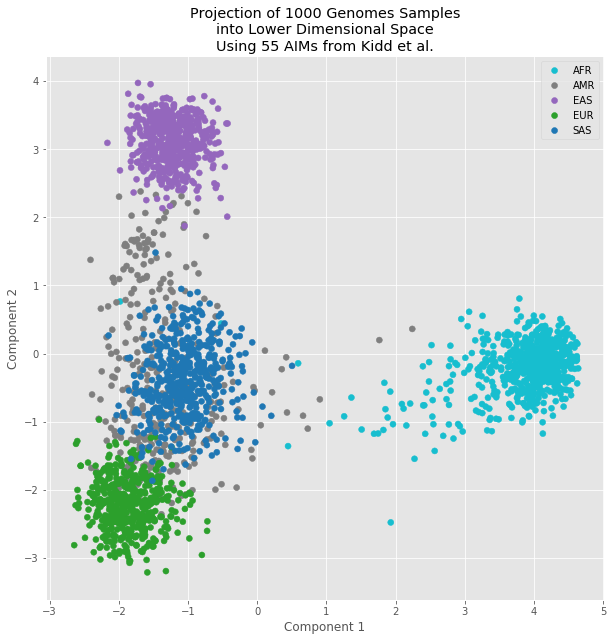

In [57]:
plot_samples(X_emb, x_component=1, y_component=2)

In [58]:
def generate_figure_image(groups, layout):
    data = []

    for idx, val in groups:
        if idx == 'me':
            scatter = go.Scatter3d(
            name=idx,
            x=val.loc[:, 'component1'],
            y=val.loc[:, 'component2'],
            z=val.loc[:, 'component3'],
            text=[idx for _ in range(val.loc[:, 'component1'].shape[0])],
            textposition='middle right',
            mode='markers',
            marker=dict(
                size=12,
                symbol='diamond'
                )
            )
        else:
            scatter = go.Scatter3d(
                name=idx,
                x=val.loc[:, 'component1'],
                y=val.loc[:, 'component2'],
                z=val.loc[:, 'component3'],
                text=[idx for _ in range(val.loc[:, 'component1'].shape[0])],
                textposition='middle right',
                mode='markers',
                marker=dict(
                    size=4,
                    symbol='circle'
                )
            )
        data.append(scatter)

    figure = go.Figure(
        data=data,
        layout=layout
    )
    return figure

In [59]:
layout = go.Layout(
            margin=dict(l=0, r=0, b=0, t=0),
            scene=dict(
                xaxis=dict(
                    title='Component 1',
                    showgrid=True,
                    zeroline=False,
                    showticklabels=True
                ),
                yaxis=dict(
                    title='Component 2',
                    showgrid=True,
                    zeroline=False,
                    showticklabels=True
                ),
                zaxis=dict(
                    title='Component 3',
                    showgrid=True,
                    zeroline=False,
                    showticklabels=True
                )
            )
        )

In [60]:
df_dim

,component1,component2,component3
0,-1.552997,-1.867352,-0.790261
1,-1.730808,-1.883513,-0.414817
2,-1.972736,-2.060778,-0.242079
3,-2.437780,-2.292182,-0.667119
4,-2.180666,-2.179228,-0.543557
...,...,...,...
2499,-1.206667,-0.560379,0.594732
2500,-1.156203,-0.692457,-0.134053
2501,-0.767795,-0.142136,0.574305
2502,-0.693530,-0.711800,0.396731
